In [22]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

In [204]:
def build_circuit(n_qubits, depth, gate_params):
    """Build a quantum circuit and convert it to an MPO."""
    # Initialize the quantum circuit
    circuit = qtn.Circuit(n_qubits)

    for layer in range(depth):
        # Apply single-qubit RX rotations
        for i in range(n_qubits):
            theta = gate_params['single'][layer, i]
            circuit.apply_gate('rx', theta, i)

        # Apply two-qubit RZZ gates (nearest neighbors)
        for i in range(n_qubits - 1):
            for j in range(i+1, n_qubits):
                angle = gate_params['rzz'][layer, i, j]
                circuit.apply_gate('rzz', angle, i, j)

    for i in range(n_qubits):
        theta = gate_params['single'][depth-1, i]
        circuit.apply_gate('rx', depth-1, i)

    # Convert the circuit to an MPO
    #mpo = circuit.to_mpo()
    return circuit


(<Figure size 800x100 with 1 Axes>, <Axes: >)

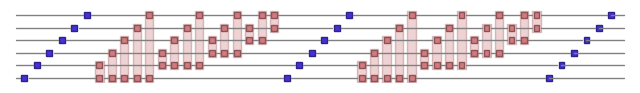

In [205]:
n_qubits = 6
depth = 2
params = {
    'single': np.random.uniform(0, 2*np.pi, (depth+1, n_qubits)),
    'rzz': np.random.uniform(0, 2*np.pi, (depth, n_qubits, n_qubits))
}

circuit = build_circuit(n_qubits, depth, params)
circuit.draw()

In [ ]:
def Singular_values(mpo,i):
    #Returns singular values of an MPO at i'th site
    A = mpo[i].data
    chi = A.shape[1]  #Bond Dimension
    A = np.transpose(A, (0,2,3,1))
    A = np.reshape(A, (-1,chi))

    B = mpo[i+1].data
    B = np.reshape(B, (chi,-1))

    S = np.linalg.svd(A@B, compute_uv=False)
    return S

In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def swap_gate():
    """Returns the SWAP gate as a (2,2,2,2) tensor."""
    SWAP = np.array([[1, 0, 0, 0], 
                     [0, 0, 1, 0], 
                     [0, 1, 0, 0], 
                     [0, 0, 0, 1]])
    return SWAP

def rzz(theta):
    """Create the RZZ gate matrix."""
    ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
    return qu.expm(-1j * theta / 2 * ZZ)


def rx(theta):
    return qu.expm(-1j * theta / 2 * qu.pauli('X'))

def u3(angles):
    theta, phi, lam = angles
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lam) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (phi + lam)) * np.cos(theta / 2)]], dtype=complex)


def decompose_two_qubit_gate(gate, cutoff=1e-14):
    gate = np.reshape(gate, (2,2,2,2))
    gate = np.transpose(gate, (0,2,1,3))
    gate = np.reshape(gate, (4,4))

    U, S, Vh = np.linalg.svd(gate)  
    S_diag = np.diag(S)  
    print("singular values: ", S)
    bd = np.sum(S>cutoff)
    print("Bond Dimension: ", bd)

    # Absorb sqrt(S) into U and Vh to get two-site tensors
    U_new = U @ np.sqrt(S_diag)
    Vh_new = np.sqrt(S_diag) @ Vh

    U_new = U_new[:,:bd]
    Vh_new = Vh_new[:bd,:]

    U_new = (U_new.T).reshape(1, -1, 2, 2)
    Vh_new = Vh_new.reshape(-1, 1, 2, 2)

    return U_new, Vh_new, bd


def create_non_local_gate_mpo(gate, i, j, N):
    assert i < j
    assert i >= 0
    assert j < N
    
    tensors = []
    for _ in range(i):
        tensors.append(np.reshape(np.eye(2),(1,1,2,2)))
    
    U, V, bd = decompose_two_qubit_gate(gate)

    #if i==0: tensors.append(U.reshape((-1,2,2)))
    #else: 
    tensors.append(U)

    delta_ij = np.eye(bd)
    delta_ab = np.eye(2)
    I = np.einsum('ij,ab->ijab', delta_ij, delta_ab)

    for _ in range(i+1,j):
        tensors.append(I)

    #if j==N-1: tensors.append(V.reshape((-1,2,2)))
    #else: 
    tensors.append(V)

    for _ in range(j+1,N):
        tensors.append(np.reshape(np.eye(2),(1,1,2,2)))

    print([itm.shape for itm in tensors])
    mpo = qtn.MatrixProductOperator(tensors)
    print(mpo.show())

    return mpo


def U3_layer_mpo(angles, N):
    tensors = []
    for i in range(N):
        gate = u3(angles[3*i:3*(i+1)])
        #if i==0 or i==N-1: tensors.append(gate.reshape(1,2,2))
        #else: 
        tensors.append(gate.reshape(1,1,2,2))

    mpo = qtn.MatrixProductOperator(tensors)
    return mpo

In [252]:
mpo = create_non_local_gate_mpo(np.random.randn(4,4),5,6,6)
mpo

singular values:  [2.08343298 2.07725107 0.82511461 0.36591692]
Bond Dimension:  4
[(1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 4, 2, 2), (4, 1, 2, 2)]
 1│1│1│1│1│1│4│1 
+─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │  
None


MatrixProductOperator(tensors=7, indices=21, L=7, max_bond=4)

In [239]:
mpo = U3_layer_mpo(np.random.randn(18),6)
mpo

MatrixProductOperator(tensors=6, indices=18, L=6, max_bond=1)

In [ ]:

def build_mpo(n_qubits, depth, params):
    """Build compressed MPO with explicit gate tensors"""

    mpo = qtn.MPO_identity(n_qubits, dtype='complex64')
    
    for layer in range(depth):
        u3_mpo = U3_layer_mpo(params['u3'][layer],n_qubits)
        mpo.apply(u3_mpo, compress=True)

        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                theta = params['zz'][layer, i, j]
                gate_matrix = rzz(theta)
                gate_mpo = create_non_local_gate_mpo(gate_matrix, i, j, n_qubits)

                #mpo._apply_mpo(gate_mpo, compress = True) 
                mpo.apply(gate_mpo, compress=True)

    u3_mpo = U3_layer_mpo(params['u3'][depth],n_qubits)
    mpo.apply(u3_mpo, compress=True)

    return mpo

n_qubits = 6
depth = 2
params = {
    'u3': np.random.uniform(0, 2*np.pi, (depth+1, 3*n_qubits)),
    'zz': np.random.uniform(0, 2*np.pi, (depth, n_qubits, n_qubits))
}

mpo = build_mpo(n_qubits, depth, params)
mpo

singular values:  [1.93887619e+00 4.90672108e-01 9.24446373e-33 5.37150428e-65]
Bond Dimension:  2


ValueError: axes don't match array

In [ ]:
def apply_mpo_to_state(mpo, initial_state):
    """Apply the MPO to an initial state represented as an MPS."""
    # Create MPS from the initial computational basis state
    mps = qtn.MPS_computational_state(initial_state)
    # Apply the MPO to the MPS
    result_mps = mpo @ mps
    return result_mps

In [171]:
mpo.trace()

-517.8616254103656

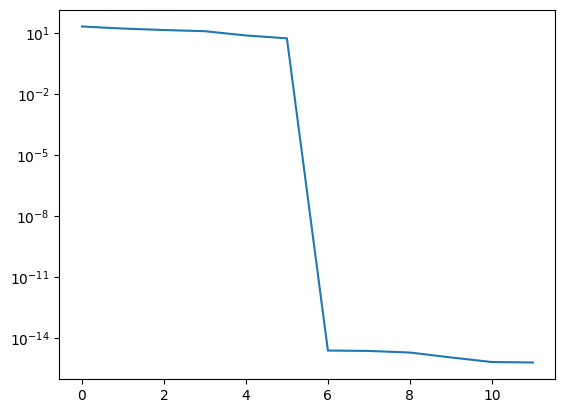

In [175]:
import matplotlib.pyplot as plt
plt.semilogy(Singular_values(mpo, 3))

In [87]:
id_mpo = qtn.MPO_identity(n)

In [89]:
id_mpo.show()

│1│1│1│1│1│
●─●─●─●─●─●
│ │ │ │ │ │


In [ ]:
id_mpo[0] = 